In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [5]:
from clustering.utils import *

In [ ]:
#%cd ..

/home/anuar/PycharmProjects/master-thesis


# Import Data

In [6]:
df, answers_train, answers, info_dict = get_cluster_input_data_new(data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat,gender,postnr,region,...,Q16_Other,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom
0,6.25,5.000000,2.75,3.5,4.666667,6.00,6.0,0,4700,Zealand,...,1,0,0,NaN,NaN,4,1,4,15,0
1,5.25,1.500000,1.25,5.0,1.666667,1.25,3.5,0,4000,Zealand,...,0,1,0,NaN,NaN,4,0,0,1,0
2,7.00,6.833333,5.50,6.0,4.666667,0.00,4.0,0,8543,Central,...,0,0,0,NaN,NaN,0,0,0,0,1
3,6.75,6.500000,6.75,7.0,4.000000,0.25,1.5,1,3760,Capital,...,0,0,0,NaN,NaN,0,0,1,0,0
4,6.50,7.000000,7.00,6.0,2.333333,0.25,4.5,0,4200,Zealand,...,0,0,0,NaN,NaN,0,1,0,0,0


In [7]:
info_dict

{'cluster_input_cols': ['F0_cautious_behaviour',
  'F1_perception_advice',
  'F2_applicability_usefullness_advice',
  'F3_behaviour_others',
  'F4_consequence_advice',
  'F5_no_contacts',
  'F6_perceived_threat'],
 'data': 'fa_data',
 'data_path': 'data/preprocessing/dim_reduction/220513_fa_data.csv',
 'end_train': '2020-12-01',
 'scaler_type': 'MinMaxScaler()',
 'start_train': '2020-07-31'}

In [8]:
print('Time period from ' + str(min(df.date)) + ' to ' + str(max(df.date)))

Time period from 2020-08-01 00:00:00 to 2021-02-01 00:00:00


In [9]:
behaviour_cols = info_dict['cluster_input_cols']
behaviour_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice',
 'F5_no_contacts',
 'F6_perceived_threat']

In [ ]:
answers_sampled = pd.DataFrame(answers).sample(20000).to_numpy()

In [18]:
answers_sampled = answers_train

# Silhouette Plot

In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
X = answers_train
range_n_clusters = np.arange(2, 11).tolist()

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Output hidden; open in https://colab.research.google.com to view.

# K-means clustering

## Elbow approach to determine ideal amount of clusters

In [19]:
distortions = []
distortions_k = []
list_ch_score = []
list_silhouette_score = []
K = range(1,10)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(answers_sampled)
    labels = kmeanModel.predict(answers_sampled)
    if k>1:
      ch_score = metrics.calinski_harabasz_score(answers_sampled, labels)
      list_ch_score.append(ch_score)
      silhouette_score = metrics.silhouette_score(answers_sampled, labels, metric='euclidean')
      list_silhouette_score.append(silhouette_score)

    distortions.append(kmeanModel.inertia_)
    distortions_k.append(kmeanModel.inertia_/k)



100%|██████████| 19/19 [04:28<00:00, 14.14s/it]


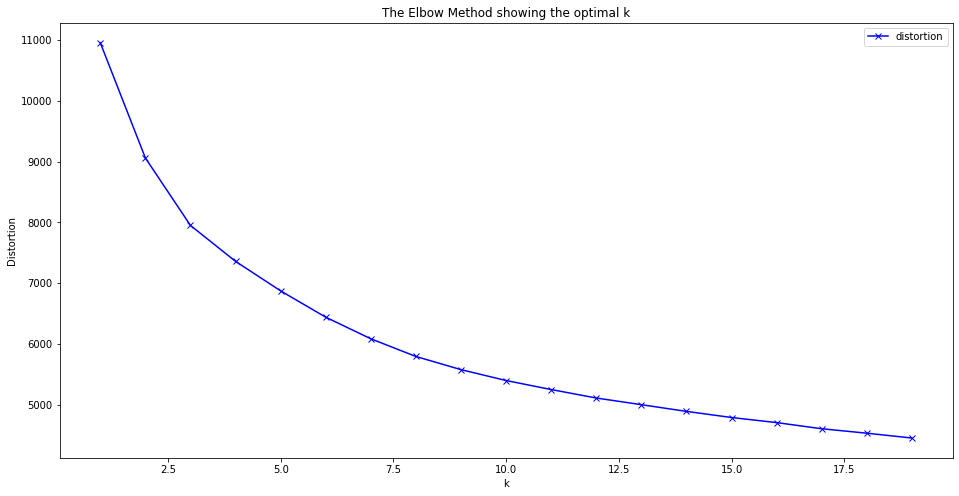

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-', label='distortion')
#plt.plot(K, distortions_k, 'rx-', label='distortion/K')
plt.legend()
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

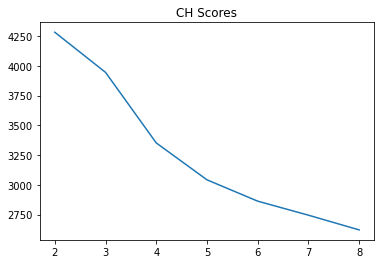

In [ ]:
plt.plot(range(2,9), list_ch_score)
plt.title('CH Scores')
plt.show()

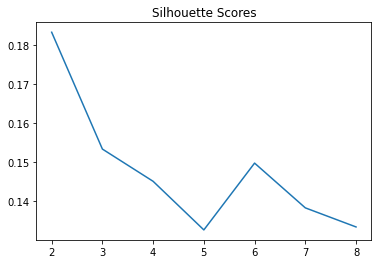

In [ ]:
plt.plot(range(2,9), list_silhouette_score)
plt.title('Silhouette Scores')
plt.show()

In [ ]:
list_silhouette_score

[0.1832883642375372,
 0.15330042534610033,
 0.14502088122632936,
 0.13254695049401793,
 0.14969573457657653,
 0.13820986494309528,
 0.13330860741292314]

## K-means fit

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(answers)

In [ ]:
df['group']=kmeans.labels_

In [ ]:
df.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,gender,...,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom,group
0,-1.136979,-0.916749,-0.659621,0.396104,1.268714,1.813853,-1.482695,-1.572988,-0.333627,0.0,...,0.0,0.0,NaN,NaN,4.0,1.0,4.0,15.0,0.0,1
1,-1.317027,0.587581,-1.392977,0.991426,0.829220,-0.199629,-0.328054,0.789160,1.636139,0.0,...,1.0,0.0,NaN,NaN,4.0,0.0,0.0,1.0,0.0,1
2,-1.630848,0.430191,0.923452,-0.009860,-0.634810,0.631976,-0.852655,-0.169432,0.603593,0.0,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,2
3,1.791578,-0.164591,-0.336503,1.647900,0.016413,-0.520565,-0.869899,0.422450,-0.130984,1.0,...,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,2
4,-1.370369,-0.498751,0.542570,-0.503827,-1.390884,0.551053,0.878819,-0.160853,-0.594420,0.0,...,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1


In [ ]:
df_sample = df.sample(20000) # used only for quick results, must be changed back to only df to get real score

X = df_sample[behaviour_cols].to_numpy()
labels = df_sample.group.to_numpy()
metrics.silhouette_score(X, labels, metric='euclidean')

0.09500070457126314

K-Means Silhouette Scores:
- 2 Cluster: 0.17
- 3 Cluster: 0.12
- 4 Cluster: 0.11
- 5 Cluster: 0.09
- 7 Cluster: 0.12

# Saving Data

In [ ]:
df.to_csv("data/clustering/220415_k_means_grouped_data.csv",index=False)